<a href="https://colab.research.google.com/github/bramvandeurzen934/Group16_ECG/blob/normalisation-and-feature-selection/assignment_ecg_normalisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TM10007 Assignment template -- ECG data

# Introduction

The objective of this notebook is to predict if a ECG recording is normal or abnormal. The features are acquired from Fourier analysis.

This notebook covers the following components:
*   **Data description and visualization**: data exploration to get acquainted with the data structure.
*   **Preprocessing**: this section consists of scaling, outliers, etc.
*   **Feature selection and extraction**: methods to select features such as Greed feature selection and extract features such as PCA will be applied.
*   **Classifier**: the apprioriate classifier will be selected based on theoretical knowledge or experiments.
*   **Experimental and evaluation setup**: evaluation of the ECG dataset on the model.







# Data description and visualization

## Data loading

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [1]:
# Run this to use from colab environment
!git clone https://github.com/bramvandeurzen934/Group16_ECG.git

import zipfile
import os
import pandas as pd

with zipfile.ZipFile('/content/Group16_ECG/ecg_data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/Group16_ECG')

data = pd.read_csv('/content/Group16_ECG/ecg_data.csv', index_col=0)

Cloning into 'Group16_ECG'...
remote: Enumerating objects: 171, done.
remote: Counting objects: 100% (157/157), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 171 (delta 98), reused 112 (delta 65), pack-reused 14
Receiving objects: 100% (171/171), 71.64 MiB | 30.61 MiB/s, done.
Resolving deltas: 100% (100/100), done.


## Data description

In [2]:
# data exploration
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')


The number of samples: 827
The number of columns: 9001


In [ ]:
print('Number of unique values: \n',data.nunique().value_counts())
print('\n')
print('Number of datatypes present: \n',data.dtypes.value_counts())


Number of unique values: 
 827    6000
826    1500
824    1500
2         1
Name: count, dtype: int64


Number of datatypes present: 
 float64    9000
int64         1
Name: count, dtype: int64


There is a difference in unique numbers for different features. In the folllowing code we will look for explanations for these discongruity.

The dataset contains 9000 columns with floating variables: the outcomes of the fourrier analysis and one column with integers: the label (0 or 1). No categorical variables are present in the data.

In [ ]:
print('Number of missing values:',data.isna().sum(1).sum())

Number of missing values: 0


There are no missing values present. An assumption of the input data in our model is that missing values should be handled in a appropriate manner depending on the frequency/distribution of the missing values.

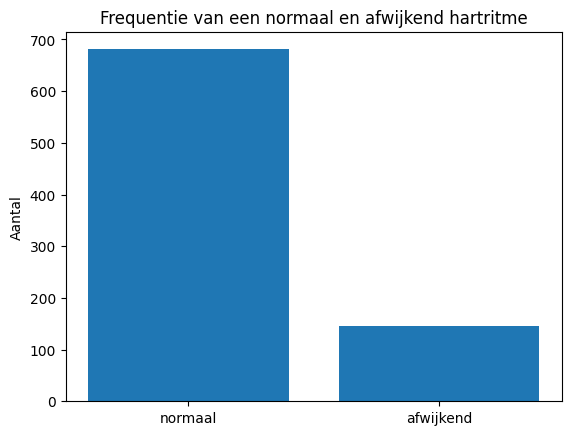

Ratio normal over abnormal ECG labels: 4.66


In [3]:
import matplotlib.pyplot as plt
# Verhoudingen van de groepen
text = ['normaal','afwijkend']
labels = data['label']
lst_labels = list(labels)
frequentie = [lst_labels.count(0), lst_labels.count(1)]
plt.bar(text, frequentie)
plt.title('Frequentie van een normaal en afwijkend hartritme')
plt.ylabel('Aantal')
plt.show()

print(f'Ratio normal over abnormal ECG labels: {lst_labels.count(0)/lst_labels.count(1):.2f}')

The dataset is unbalanced: the number of normal ECG labels is almost 5 times larger than abnormal ECG labels.

## Data exploration (different number of unique values)

In [ ]:
data.loc[:,data.nunique() == 824]

,10_0,10_1,10_2,10_3,10_4,10_5,10_6,10_7,10_8,10_9,...,11_740,11_741,11_742,11_743,11_744,11_745,11_746,11_747,11_748,11_749
0,41.875218,35.634043,55.146901,78.508691,65.077005,207.545620,129.133645,41.216843,17.853091,12.161600,...,0.172247,0.078753,0.379885,0.182930,0.231552,0.222432,0.154919,0.158616,0.269249,0.112248
1,2455.348262,209.899760,73.209855,27.544186,31.050826,33.860348,45.695430,72.086416,163.059456,50.716332,...,0.930850,0.804160,0.809705,0.830032,0.774368,0.798178,0.853519,0.827946,0.859936,0.742673
2,1.075515,16.664705,21.294223,58.297014,46.693010,50.257416,43.874721,59.746670,54.488864,18.647156,...,0.032276,0.156080,0.102070,0.168276,0.120385,0.064254,0.077670,0.059857,0.098506,0.098288
3,1.038323,2.282563,23.090713,18.327925,5.515731,28.523230,227.485074,36.965269,9.597894,13.806125,...,0.104485,0.238274,0.096733,0.030739,0.170214,0.052079,0.179360,0.226222,0.092000,0.192559
4,2.652258,1.002665,7.184702,9.510938,21.350962,19.967950,5.677285,47.973415,59.175184,15.896775,...,0.078848,0.056914,0.059116,0.050098,0.152588,0.129712,0.047342,0.058446,0.141610,0.129477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
822,72.440238,98.826586,38.532140,69.437331,72.882899,67.224122,76.664186,40.275881,44.348151,13.289430,...,0.094904,0.024548,0.056174,0.029438,0.169014,0.111257,0.058975,0.112644,0.155580,0.061931
823,31.976060,36.614306,29.262171,27.144629,27.921450,32.460702,117.348964,211.829206,62.371423,37.218614,...,0.683881,0.808183,0.728553,0.743050,0.735316,0.724321,0.671816,0.714386,0.771741,0.757218
824,14.675614,9.904811,0.468492,17.177705,20.555421,34.692365,226.525387,76.634711,48.578796,34.150803,...,0.032643,0.103234,0.113550,0.102557,0.131152,0.057736,0.061432,0.068036,0.159615,0.077114
825,4.708455,10.636212,18.296060,22.489212,20.971064,18.732253,70.265628,69.108944,27.271947,12.750125,...,0.019307,0.150481,0.073634,0.104637,0.164451,0.055838,0.060012,0.057874,0.060548,0.116350


In [ ]:
data[data['10_0'].duplicated()]['10_0']

542    0.0
601    0.0
790    0.0
Name: 10_0, dtype: float64

In [ ]:
print('zeros in 826 \n',data[data['7_0'].duplicated()]['7_0'])
print('zeros in 826 \n',data[data['8_0'].duplicated()]['8_0'])
print('zeros in 824 \n',data[data['10_0'].duplicated()]['10_0'])
print('zeros in 824 \n',data[data['11_0'].duplicated()]['11_0'])


zeros in 826 
 784    0.0
Name: 7_0, dtype: float64
zeros in 826 
 537    0.0
Name: 8_0, dtype: float64
zeros in 824 
 542    0.0
601    0.0
790    0.0
Name: 10_0, dtype: float64
zeros in 824 
 385    0.0
434    0.0
446    0.0
Name: 11_0, dtype: float64


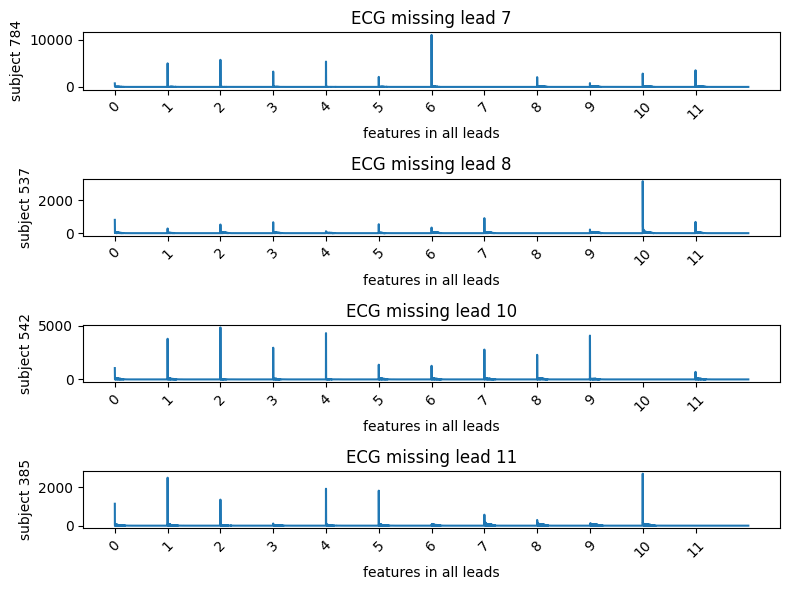

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, axes = plt.subplots(4, 1, figsize=(8, 6))

sns.lineplot(x = data.columns,y=data.iloc[784,:],ax = axes[0])
sns.lineplot(x = data.columns,y=data.iloc[537,:],ax = axes[1])
sns.lineplot(x = data.columns,y=data.iloc[542,:],ax = axes[2])
sns.lineplot(x = data.columns,y=data.iloc[385,:],ax = axes[3])


axes[0].set_xticks(np.arange(0,9000, 750), labels=['0', '1', '2', '3', '4', '5','6','7','8','9','10','11'],rotation = 45)
axes[1].set_xticks(np.arange(0,9000, 750), labels=['0', '1', '2', '3', '4', '5','6','7','8','9','10','11'],rotation = 45)
axes[2].set_xticks(np.arange(0,9000, 750), labels=['0', '1', '2', '3', '4', '5','6','7','8','9','10','11'],rotation = 45)
axes[3].set_xticks(np.arange(0,9000, 750), labels=['0', '1', '2', '3', '4', '5','6','7','8','9','10','11'],rotation = 45)

axes[0].set(ylabel = 'subject 784',
            xlabel = 'features in all leads',
            title = 'ECG missing lead 7')
axes[1].set(ylabel = 'subject 537',
            xlabel = 'features in all leads',
            title = 'ECG missing lead 8')
axes[2].set(ylabel = 'subject 542',
            xlabel = 'features in all leads',
            title = 'ECG missing lead 10')
axes[3].set(ylabel = 'subject 385',
            xlabel = 'features in all leads',
            title = 'ECG missing lead 11')

plt.tight_layout()

plt.show()


This figure shows that for a few persons (n = 8), no recordings are available for one specific lead. This causes a lack of features for these persons.

In total there are 12 leads (0-11) and each lead has 750 features. The features in the columns are written as 0_20 with 0 the lead number and 20 the corresponding feature.



## Data visualization

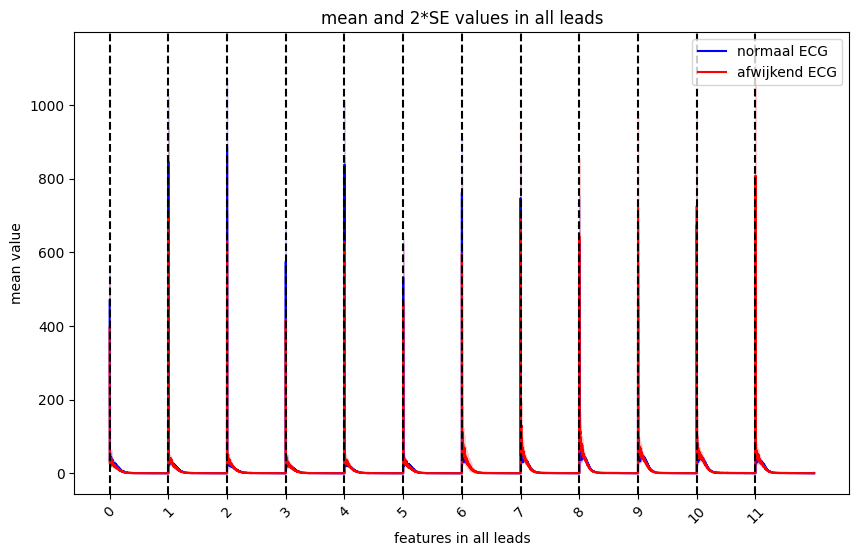

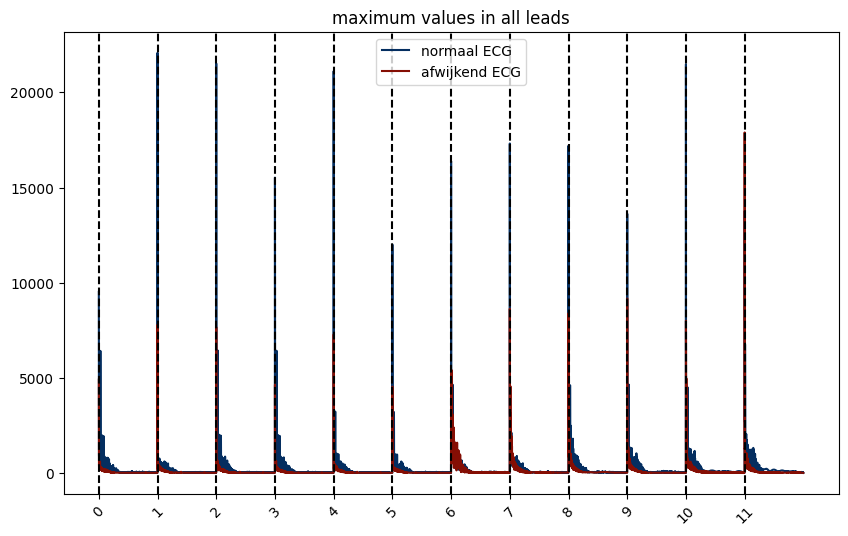

In [ ]:
data_mean_0 = data[data['label']==0].mean()
data_mean_1 = data[data['label']==1].mean()

upperbound_0 = data_mean_0 + 2 * data[data['label']==0].sem()
lowerbound_0 = data_mean_0 - 2 * data[data['label']==0].sem()

upperbound_1 = data_mean_1 + 2 * data[data['label']==1].sem()
lowerbound_1 = data_mean_1 - 2 * data[data['label']==1].sem()

data_max_0 = data[data['label'] == 0].max()
data_max_1 = data[data['label'] == 1].max()


# figure with mean values
plt.figure(figsize=[10,6])
plt.plot(data.columns,data_mean_0,color = 'b')
plt.plot(data.columns,data_mean_1,color = 'r')
plt.fill_between(data.columns,lowerbound_0,upperbound_0,alpha = 0.2, color = 'b')
plt.fill_between(data.columns,lowerbound_1,upperbound_1,alpha = 0.2, color = 'r')

for v_line in np.arange(0,9000,750):
  plt.axvline(v_line,ymin = 0,color = 'k',linestyle = '--')

plt.legend(['normaal ECG','afwijkend ECG'])
plt.xticks(np.arange(0,9000, 750), labels=['0', '1', '2', '3', '4', '5','6','7','8','9','10','11'],rotation = 45)
plt.xlabel('features in all leads')
plt.ylabel('mean value')
plt.title('mean and 2*SE values in all leads')

plt.show()

# figure with max values
plt.figure(figsize= [10,6])
plt.plot(data.columns,data_max_0,color = '#042e60')
plt.plot(data.columns,data_max_1,color = '#850e04')

for v_line in np.arange(0,9000,750):
  plt.axvline(v_line,ymin = 0,color = 'k',linestyle = '--')

plt.xticks(np.arange(0,9000, 750), labels=['0', '1', '2', '3', '4', '5','6','7','8','9','10','11'],rotation = 45)
plt.legend(['normaal ECG','afwijkend ECG'])
plt.title('maximum values in all leads')

plt.show()


Based on this figure: we decided to look deeper to the first 200 features for every lead because this area is easier to visualize. This doesn't mean that there is no useful information in the other feature but because of the scaling the feature further in the lead are smaller in the visualization.

Beside this you can see that for every lead in the beginning features reach high values. Because these values are consistently high we assume that these values aren't errors but contain usefull information. Therefore, we decided to keep the perceived outliers. These outliers go up to 1000. If values in a magnitude of millions were perceived, outliers handling would be appropriate. As no background is known about the features it is hard to estimate if outliers are errors or useful information

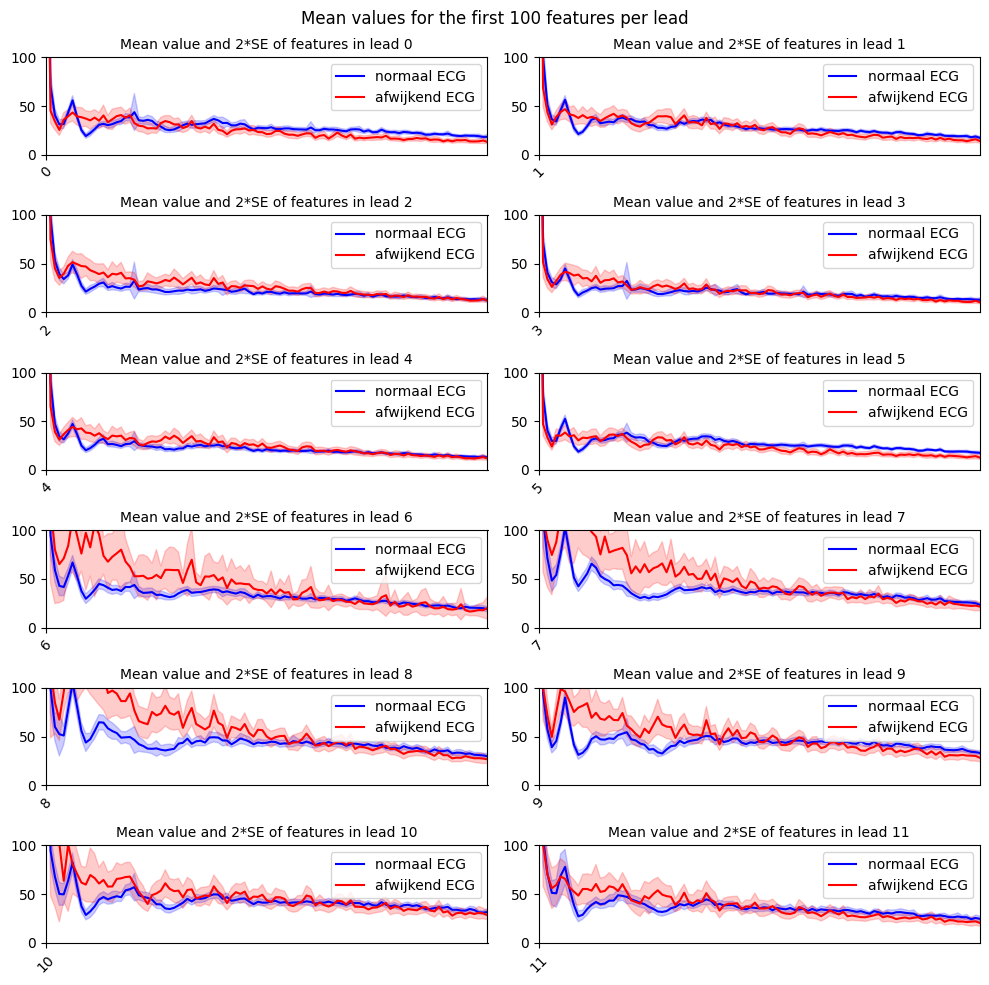

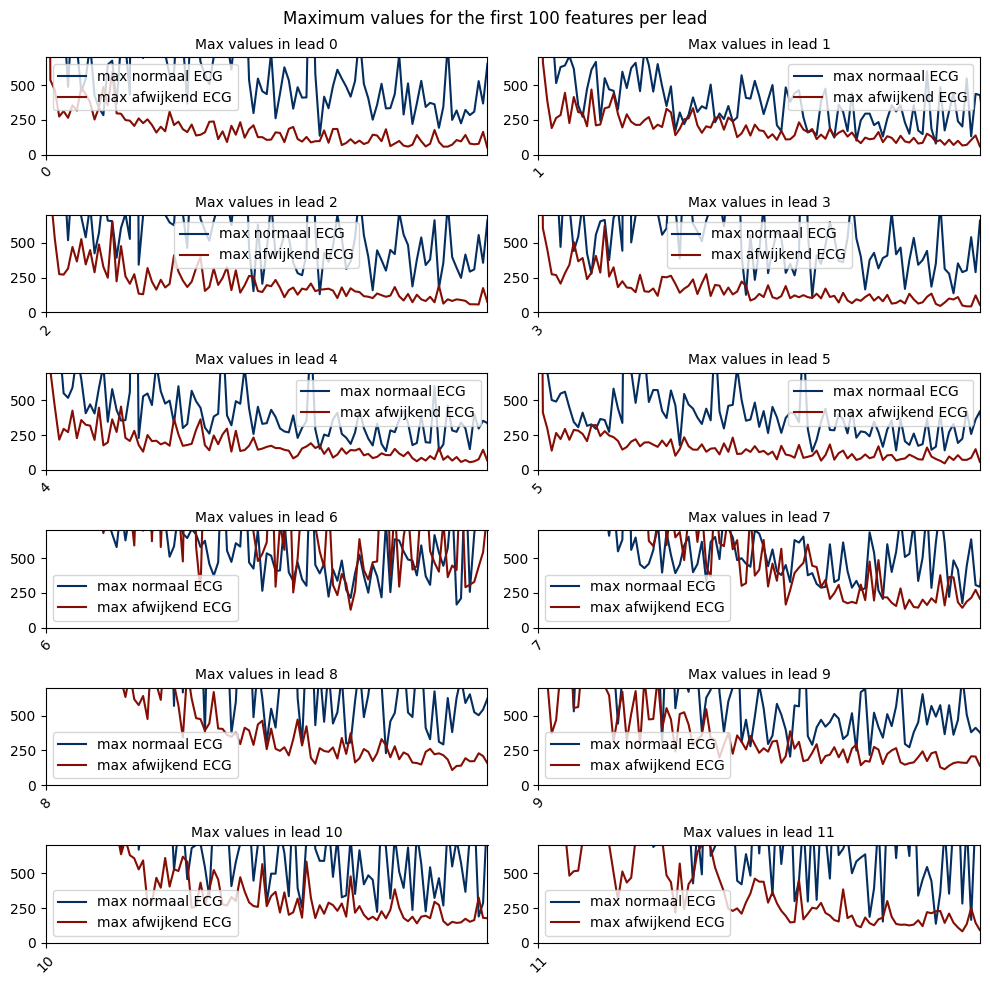

In [ ]:
# looking at the first 100 features for a better visualization

plt.figure(figsize = [10,10])

number_leads = np.arange(0,12,1)

for number_lead in number_leads:
  ax = plt.subplot(6,2,number_lead+1)
  ax.plot(data.columns,data_mean_0,color = 'b')
  ax.plot(data.columns,data_mean_1,color = 'r')
  ax.fill_between(data.columns,lowerbound_0,upperbound_0,alpha = 0.2, color = 'b')
  ax.fill_between(data.columns,lowerbound_1,upperbound_1,alpha = 0.2, color = 'r')
  ax.set_xticks(np.arange(0,9000, 750), labels=['0', '1', '2', '3', '4', '5','6','7','8','9','10','11'],rotation = 45)
  ax.set_xlim(number_lead*750,(number_lead)*750+100)
  ax.set_ylim(0,100)
  ax.set_title(f'Mean value and 2*SE of features in lead {number_lead}',fontsize = 10)
  ax.legend(['normaal ECG','afwijkend ECG'])
plt.suptitle('Mean values for the first 100 features per lead')
plt.tight_layout()
plt.show()

plt.figure(figsize = [10,10])
for number_lead in number_leads:
  ax = plt.subplot(6,2,number_lead+1)
  ax.plot(data.columns,data_max_0,color = '#042e60')
  ax.plot(data.columns,data_max_1,color = '#850e04')
  ax.set_xticks(np.arange(0,9000, 750), labels=['0', '1', '2', '3', '4', '5','6','7','8','9','10','11'],rotation = 45)
  ax.set_xlim(number_lead*750,(number_lead)*750+100)
  ax.set_ylim(0,700)
  ax.set_title(f'Max values in lead {number_lead}',fontsize = 10)
  ax.legend(['max normaal ECG','max afwijkend ECG'])
plt.suptitle('Maximum values for the first 100 features per lead')
plt.tight_layout()
plt.show()


Based on these figures we can conclude that for some patients no ECG was recorded in certain leads. Although no features are present in these leads we choose to retain these samples as information other leads may be sufficient to make a classification.

However, users of this model should identify if leads are missing in the original data. An assumption of the input data in our model is that at least 11 of the 12 leads must be present.

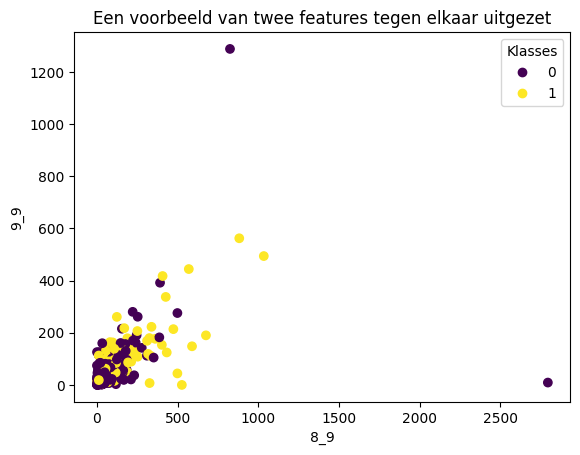

In [ ]:
# Voorbeeld van een eerste plotje
import matplotlib.pyplot as plt

feature_1 = '8_9'
feature_2 = '9_9'
scatter = plt.scatter(data[feature_1],data[feature_2], c = labels)
plt.title('Een voorbeeld van twee features tegen elkaar uitgezet')
plt.xlabel(feature_1)
plt.ylabel(feature_2)
legend1 = plt.legend(*scatter.legend_elements(),
                    loc="upper right", title="Klasses")
plt.show()

We can make a scatter of features. We observe that values have different magnitudes. Scaling is really important to relate the features.

## Data normal distribution

In [7]:
# Testen per feature of het normaal verdeeld is per groep
from scipy.stats import shapiro

# Parametric testing per class
#Defining two dataframes: one for each class
data_healthy = data[data["label"] == 0]
data_abnormal = data[data["label"] == 1]

data_healthy = data_healthy.drop('label',axis = 1)
data_abnormal = data_abnormal.drop('label',axis = 1)

n_parametric_healthy = 0
for columnname in data_healthy.columns:
  statistics = shapiro(list(data_healthy[columnname]))
  if statistics[1] > 0.05:
    n_parametric_healthy += 1

n_parametric_abnormal = 0
for columnname in data_abnormal.columns:
  statistics = shapiro(list(data_abnormal[columnname]))
  if statistics[1] > 0.05:
    n_parametric_abnormal += 1

print(f'''Healthy: {n_parametric_healthy} ({n_parametric_healthy/(data_healthy.shape[1])*100}%) features are normally distributed
Abnormal: {n_parametric_abnormal} ({n_parametric_abnormal/(data_abnormal.shape[1])*100}%) features are normally distributed''')

Healthy: 0 (0.0%) features are normally distributed
Abnormal: 0 (0.0%) features are normally distributed


conclusie: Aan de hand van een shapiro test met een p-waarde van 0.05 is gebleken dat alle features normaal verdeeld zijn.

## Data non-linearity
Hieronder wordt een tweezijdige T-test gedaan voor de data. Er wordt gekeken of er een significant verschil is tussen de gezond of ongezond groep per feature. De meest significant verschillende features worden vervolgens gebruikt om een pairplot te maken

Without multiple testing correction, 2625 features significantly differ between the two classes (with bonferroni correction 236)


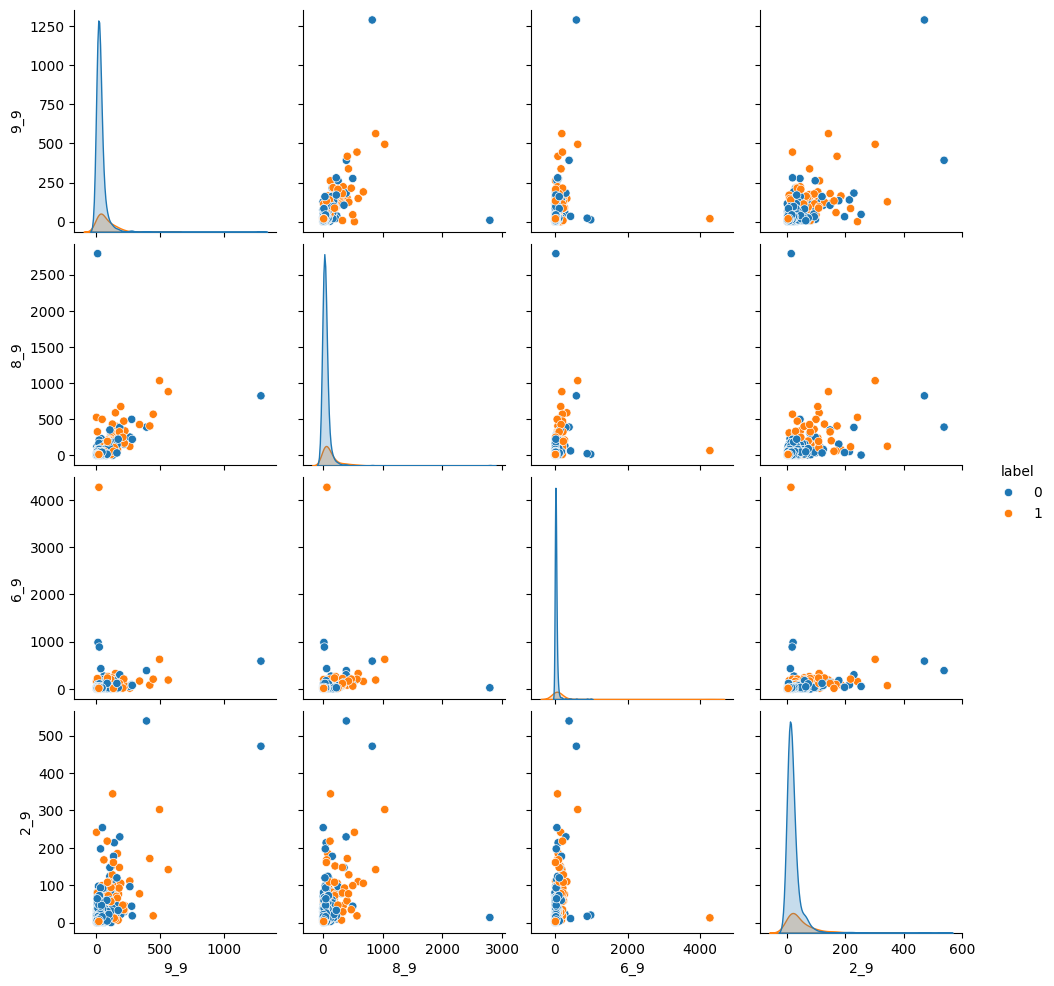

In [8]:
from scipy.stats import shapiro, mannwhitneyu
import numpy as np
import seaborn as sns

# significantly differently features
dict_p_values = dict()
for kolom in data_healthy.columns:
  p_value = mannwhitneyu(data_healthy[kolom],data_abnormal[kolom])
  dict_p_values[kolom] = p_value[1]

dict_sorted_p_values = dict(sorted(dict_p_values.items(),key = lambda x:x[1]))
features_sorted = list(dict_sorted_p_values.keys())
p_values = np.array(list(dict_sorted_p_values.values()))

print(f'Without multiple testing correction, {sum(p_values< (0.05))} features significantly differ between the two classes (with bonferroni correction {sum(p_values< (0.05/9000))})')

most_sign_data = data[features_sorted[:4] + ["label"]]
sns.pairplot(data = most_sign_data,hue = "label")

In [13]:
features_selected = features_sorted[:20]

In [14]:
features_selected

['9_9',
 '8_9',
 '6_9',
 '2_9',
 '6_10',
 '7_9',
 '10_9',
 '6_8',
 '11_9',
 '8_10',
 '8_27',
 '3_9',
 '1_9',
 '8_8',
 '8_28',
 '4_9',
 '5_123',
 '5_138',
 '7_8',
 '0_123']

Conclusion: normal and abnormal ECG labels the are not linearly separable in these features. We may need to use kernels to cover the non-linear behaviour of the data.

# Preprocessing
Till now only visualizations and data exploration were performed.
No computations to the data were done, as the test data should not be spoiled.
Before preprocessing we will first split the train and testdata.
In preprocessing normalisation (scaling) and feature extraction (PCA)

## Train test split

In [18]:
from sklearn.model_selection import train_test_split
X = data.copy()
y = X.pop('label')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [19]:
from sklearn import preprocessing
import pandas as pd
# robust scaler
scaler_rob = preprocessing.RobustScaler()
scaler_rob.fit(X_train)

# chose scaler is robust scaler
X_train = pd.DataFrame(scaler_rob.transform(X_train),index = X_train.index, columns = X_train.columns)
X_test = pd.DataFrame(scaler_rob.transform(X_test), index = X_test.index, columns = X_test.columns)

In [23]:
# select features
X_train = X_train.loc[:,features_selected]
X_test = X_test.loc[:,features_selected]

In [27]:
from sklearn.svm import SVC
from sklearn.metrics import f1_score, accuracy_score

clf = SVC(kernel = 'linear',C = 0.1)
clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)
fscore = f1_score(y_pred,y_test)
accuracy = accuracy_score(y_pred,y_test)

In [28]:
fscore

0.2631578947368421

In [29]:
accuracy

0.8313253012048193

## Normalisation

In [ ]:
from sklearn import preprocessing

# standardscaler
scaler_st = preprocessing.StandardScaler()
scaler_st.fit(X_train)
X_train_st_scaled = pd.DataFrame(scaler_st.transform(X_train),columns = X_train.columns,index = X_train.index)
X_test_st_scaled = scaler_st.transform(X_test)

# smin max scaler
scaler_max = preprocessing.MinMaxScaler()
scaler_max.fit(X_train)
X_train_max_scaled = pd.DataFrame(scaler_max.transform(X_train),columns = X_train.columns,index = X_train.index)
X_test_max_scaled = scaler_max.transform(X_test)

# robust scaler
scaler_rob = preprocessing.RobustScaler()
scaler_rob.fit(X_train)
X_train_rob_scaled = pd.DataFrame(scaler_rob.transform(X_train),columns = X_train.columns,index = X_train.index)
X_test_rob_scaled = scaler_rob.transform(X_test)

# chose scaler is robust scaler
X_train_scaled = scaler_rob.transform(X_train)
X_test_scaled = scaler_rob.transform(X_test)

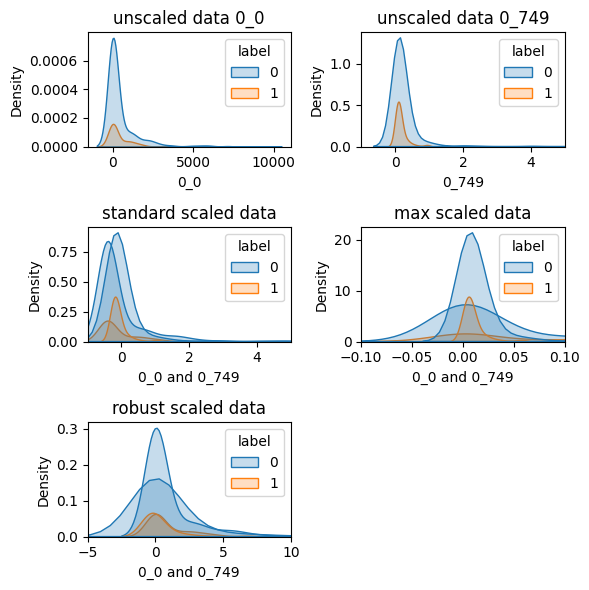

In [ ]:
# figures showing the scalers
fig, axs = plt.subplots(3,2,figsize = [6,6])

sns.kdeplot(data = X_train,x = '0_0',hue = y_train,fill = True, ax = axs[0,0])
axs[0,0].set(title = 'unscaled data 0_0')

sns.kdeplot(data = X_train,x = '0_749',hue = y_train,fill = True, ax = axs[0,1])
axs[0,1].set(title = 'unscaled data 0_749',
             xlim = [-1,5])

sns.kdeplot(data = X_train_st_scaled,x = '0_0',hue = y_train,fill = True, ax = axs[1,0])
sns.kdeplot(data = X_train_st_scaled,x = '0_749',hue = y_train,fill = True, ax = axs[1,0])
axs[1,0].set(title = 'standard scaled data',
             xlim = [-1,5],
             xlabel = '0_0 and 0_749')

sns.kdeplot(data = X_train_max_scaled,x = '0_0',hue = y_train,fill = True, ax = axs[1,1])
sns.kdeplot(data = X_train_max_scaled,x = '0_749',hue = y_train,fill = True, ax = axs[1,1])
axs[1,1].set(title = 'max scaled data',
             xlim = [-0.1,0.1],
             xlabel = '0_0 and 0_749')

sns.kdeplot(data = X_train_rob_scaled,x = '0_0',hue = y_train,fill = True, ax = axs[2,0])
sns.kdeplot(data = X_train_rob_scaled,x = '0_749',hue = y_train,fill = True, ax = axs[2,0])
axs[2,0].set(title = 'robust scaled data',
             xlim = [-5,10],
             xlabel = '0_0 and 0_749')

axs[2,1].remove()

plt.tight_layout()

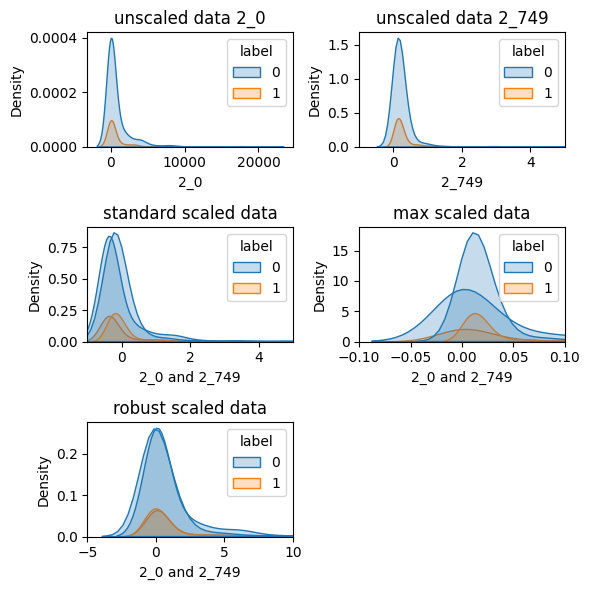

In [ ]:
# figures showing the scalers
fig, axs = plt.subplots(3,2,figsize = [6,6])

sns.kdeplot(data = X_train,x = '2_0',hue = y_train,fill = True, ax = axs[0,0])
axs[0,0].set(title = 'unscaled data 2_0')

sns.kdeplot(data = X_train,x = '2_749',hue = y_train,fill = True, ax = axs[0,1])
axs[0,1].set(title = 'unscaled data 2_749',
             xlim = [-1,5])

sns.kdeplot(data = X_train_st_scaled,x = '2_0',hue = y_train,fill = True, ax = axs[1,0])
sns.kdeplot(data = X_train_st_scaled,x = '2_749',hue = y_train,fill = True, ax = axs[1,0])
axs[1,0].set(title = 'standard scaled data',
             xlim = [-1,5],
             xlabel = '2_0 and 2_749')

sns.kdeplot(data = X_train_max_scaled,x = '2_0',hue = y_train,fill = True, ax = axs[1,1])
sns.kdeplot(data = X_train_max_scaled,x = '2_749',hue = y_train,fill = True, ax = axs[1,1])
axs[1,1].set(title = 'max scaled data',
             xlim = [-0.1,0.1],
             xlabel = '2_0 and 2_749')

sns.kdeplot(data = X_train_rob_scaled,x = '2_0',hue = y_train,fill = True, ax = axs[2,0])
sns.kdeplot(data = X_train_rob_scaled,x = '2_749',hue = y_train,fill = True, ax = axs[2,0])
axs[2,0].set(title = 'robust scaled data',
             xlim = [-5,10],
             xlabel = '2_0 and 2_749')

axs[2,1].remove()

plt.tight_layout()

Conclusions:
*   Minimum maximum scaler will not be used. When outliers are present such as in feature 0_0 we observe that distribution of feature 0_0 gets flattened. Inliers are cropped with the max scaler resulting in a deviated distribution from the original feature.
*   Robust scaler: scales the data with the IQR and median. It retains the distribution of the data especially when the distribution is not Gaussian. It is particularly useful when there is a non normal distribution.
*   Standard scaler: as there is a bit of skewness in the data of feature 0_0 we see when using the mean and standard deviation that the distribution shifts to the left. Because of outliers you can observe that the data inclines to the right (there data is not perfectly normal distributed). **When you are using standards scaled data, the mean is shifted towards the outliers and with robust scaling we don't have problems with this. **

Overall conclusions:
*   Robust scaler is preferred (other benefits: more stable and versatile)
*   Skewness is present (caused by outliers)
*   Normal distribution is perceivable (as tested by Eva before)









# PCA (feature extraction)

In [ ]:
X_train_scaled = pd.DataFrame(X_train_scaled, index = X_train.index, columns = X_train.columns)
X_train_scaled

,0_0,0_1,0_2,0_3,0_4,0_5,0_6,0_7,0_8,0_9,...,11_740,11_741,11_742,11_743,11_744,11_745,11_746,11_747,11_748,11_749
104,-0.011863,0.009004,-0.144181,1.025579,0.125386,1.020518,0.104574,0.769082,1.498220,0.237179,...,-0.497913,-0.203117,-0.328460,0.389199,0.217405,0.004408,-0.029062,-0.556494,-0.435414,-0.335344
175,5.614313,5.151303,4.447014,5.125366,2.767124,0.473697,0.821779,1.934148,1.550678,1.185821,...,0.040654,-0.314550,-0.003031,0.028014,0.294971,-0.447511,-0.300635,-0.252946,-0.073023,-0.175077
223,-0.023220,-0.323129,-0.324002,-0.442913,-0.068871,1.738902,-0.424428,-0.524070,-0.537727,-0.152847,...,-0.544349,-0.096920,0.124444,-0.540659,-0.018532,0.167248,0.131918,0.024403,0.263729,-0.351288
57,-0.020919,0.032089,-0.292480,0.319308,1.769018,0.937102,-0.341620,-0.291938,0.145380,2.941988,...,0.534838,0.456316,2.263505,1.924149,1.551693,1.322147,0.979816,0.961145,1.222732,1.813081
783,5.612341,7.311552,1.226068,2.276818,1.484578,-0.310886,-0.092753,0.267225,3.085677,0.237948,...,6.540468,6.660225,6.234730,6.892066,8.126915,7.727023,7.043606,6.906159,6.335515,7.139419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,3.123133,1.993452,9.290777,0.280212,2.013588,0.257073,0.434225,0.420666,-0.476635,0.336486,...,0.216688,-0.617929,-0.217035,-0.404367,-0.542987,-0.734110,-0.030097,-0.380290,-0.323353,-0.496280
767,2.191527,4.349844,1.453453,0.032554,-0.263993,-0.405046,-0.590886,-0.506033,-0.291125,0.513262,...,0.675468,-0.569414,-0.285923,0.254146,-0.176397,-0.049104,-0.122121,0.348027,0.674515,-0.221613
72,-0.017617,-0.325645,-0.420843,-0.598889,-0.583690,-0.466179,-0.386652,-0.531244,-0.662227,-0.476375,...,0.080202,-0.284283,0.192994,-0.563013,0.376918,-0.354526,-0.479303,-0.304667,-0.065898,-0.231296
235,0.146915,0.441627,-0.022127,-0.512356,-0.584772,-0.387590,-0.445213,1.916528,0.240764,-0.136468,...,2.131068,2.167676,2.119108,2.260536,1.922591,2.387357,1.905771,1.636938,1.819874,1.556240


In [ ]:
from sklearn.decomposition import PCA, KernelPCA

# Perform a PCA
pca = PCA(n_components=50)
pca.fit(X_train_scaled)

X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

component_names = [f"PC{i+1}" for i in range(X_train_pca.shape[1])]
X_train_pca = pd.DataFrame(X_train_pca,columns = component_names,index = X_train.index)
component_names = [f"PC{i+1}" for i in range(X_test_pca.shape[1])]
X_test_pca = pd.DataFrame(X_test_pca,columns = component_names,index = X_test.index)

X_train_pca

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50
104,135.532431,-26.778238,158.574580,-61.956183,203.082578,-2.101855,-29.659250,-25.434365,-0.736706,29.448408,...,-11.449955,9.343304,3.517050,-9.330213,-7.941341,7.821968,-5.421894,0.013815,7.048905,-0.777834
175,-48.012793,0.651820,-14.880641,-19.302425,-18.685844,-8.451336,-9.734462,-4.968183,11.674602,-0.948829,...,-4.352165,-8.498952,7.361391,8.473467,16.332981,-3.938088,3.094341,5.655735,-3.476631,-2.221230
223,-38.469589,4.905221,-8.263606,-8.455162,-12.179104,-7.508629,-6.758235,0.614405,6.427969,-6.433942,...,-5.379300,3.379956,-3.424757,2.791789,-1.963424,6.698977,-8.059689,-5.865810,-0.483422,2.024504
57,-35.573717,13.780498,-9.210837,-1.933715,-14.057160,-10.443098,6.526566,-3.053321,4.692064,-1.672041,...,4.183615,4.288387,-5.856061,-2.446572,3.590280,1.306494,-2.832912,6.669579,-3.258356,1.880331
783,153.944017,-29.770542,-57.188124,-53.624600,2.450944,-10.391995,-40.964891,55.005579,-140.866238,35.013926,...,0.140291,-1.659826,1.328500,0.629030,9.553443,3.706545,-3.639841,3.282874,2.527205,0.610347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,-64.339387,19.013381,-9.578621,-9.830020,-1.206449,-10.741063,4.632823,-16.194977,-1.357905,-3.078980,...,6.690989,-10.639003,-1.215611,7.334484,11.098475,-6.464961,-6.863849,-0.671063,-6.053095,4.774556
767,-48.473906,29.728761,2.035763,-13.005051,1.683114,-5.030375,-3.443121,-31.711657,-1.698421,4.638041,...,-0.118282,-1.758042,-2.477974,0.804310,0.913103,-1.857309,5.856783,-4.959019,-0.627634,3.683694
72,-48.684590,15.243645,-6.443996,-7.197696,-7.299651,-5.711294,5.495778,-14.507362,1.764922,-6.127806,...,-1.267406,-0.545868,-6.132526,-2.780753,-2.096964,2.995024,-2.820069,4.140652,2.012094,0.401082
235,54.270797,93.504905,-10.021845,-26.829787,53.845216,21.225054,-60.420296,-75.761025,-0.415162,62.952376,...,-1.532967,-0.018006,8.287642,3.097310,-2.364507,-0.956972,7.168079,-3.073247,6.685117,-1.304990


In [ ]:
X_test_pca = pd.DataFrame(X_test_pca,columns = component_names,index = X_test.index)
X_test_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50
370,-87.264352,33.522595,-11.885496,-14.138953,-9.397400,-8.634351,7.524459,-24.640939,25.496464,-1.724266,...,-10.242395,-2.243486,-2.015691,-4.685271,-1.700990,4.204087,17.256134,-2.532114,5.475209,-6.837616
449,-51.332459,11.572818,-4.337051,2.206829,-8.489044,-7.132270,2.908201,-11.423904,13.133042,-4.590859,...,4.791317,0.021147,-0.586844,-5.397682,-1.826325,3.448037,2.606298,3.874419,0.972155,-0.058818
808,-39.728317,10.492232,-6.861110,-9.857214,-9.944397,-4.980499,1.873715,-6.720792,8.795850,-7.066672,...,-4.324028,-3.152935,-0.659300,3.878363,3.378392,10.029789,3.388656,-6.738576,1.322365,2.241396
576,-63.045046,24.790284,-8.504558,-8.115034,-7.069758,-7.369980,10.598557,-22.622888,-3.468482,-6.359538,...,0.245941,0.870831,-3.806678,5.559161,-0.774217,-1.599174,1.460612,0.816061,2.291319,0.851807
570,-56.269646,17.197366,-11.452451,-10.443392,-8.529820,0.749737,7.100263,-15.207799,7.313860,-5.593185,...,-2.904780,0.954815,0.120326,2.194140,1.752838,3.034218,4.961862,-2.496448,1.342874,2.560824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,-26.339586,14.709986,-7.029533,-21.585982,5.303576,-16.725220,0.107428,-7.100479,-13.362361,4.021472,...,3.799823,4.246678,3.573717,-4.403513,1.817001,1.233702,-0.416954,-2.435404,-2.867152,-1.017750
760,-53.129713,-0.211291,-18.592326,-19.954311,23.364179,-14.911841,9.039953,0.130339,-21.317769,-10.519510,...,-4.975228,-3.932639,-1.644452,-1.336316,-0.249800,7.282059,4.996260,-3.960694,-5.647603,-6.470038
309,-27.221849,1.297177,-8.556484,-1.603184,-6.389540,-4.264738,-4.698743,-1.235800,-1.583147,-6.988510,...,-5.769941,-3.326040,-0.014464,-1.657309,-1.439362,-4.259050,-1.292926,-5.805897,6.146155,3.492489
134,-27.385155,1.204555,-13.239782,-10.988052,-9.275369,-5.790199,-5.031663,0.065879,-6.972608,-3.419152,...,-5.852210,-0.778926,0.470265,0.301971,3.232632,9.630871,2.292951,6.302983,6.239895,3.529820


In [ ]:
# kernel pca
kernel_pca = KernelPCA(n_components=50, kernel="rbf",gamma = 20)
kernel_pca.fit(X_train_scaled)

kernel_sig_pca = KernelPCA(n_components=50, kernel="sigmoid",gamma = 20)
kernel_sig_pca.fit(X_train_scaled)

X_train_kpca = kernel_pca.transform(X_train_scaled)
X_test_kpca = kernel_pca.transform(X_test_scaled)
X_train_skpca = kernel_sig_pca.transform(X_train_scaled)
X_test_skpca = kernel_sig_pca.transform(X_test_scaled)

component_names = [f"PC{i+1}" for i in range(X_train_kpca.shape[1])]
X_train_kpca = pd.DataFrame(X_train_kpca,columns = component_names,index = X_train.index)
component_names = [f"PC{i+1}" for i in range(X_train_skpca.shape[1])]
X_train_skpca = pd.DataFrame(X_train_skpca,columns = component_names,index = X_train.index)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KernelPCA was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KernelPCA was fitted with feature names
  warnings.warn(


Heeft dit nog toegevoegde waarde?

‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘cosine’, ‘precomputed’

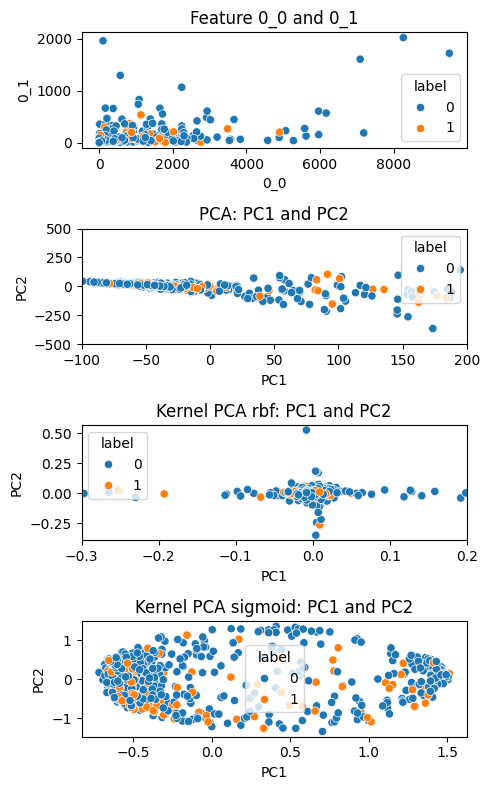

In [ ]:
fig, axs = plt.subplots(4,1,figsize = [5,8])

sns.scatterplot(data=X_train,x = '0_0',y = '0_1', hue = y_train,ax = axs[0])
axs[0].set(title = 'Feature 0_0 and 0_1')


sns.scatterplot(data = X_train_pca, x = 'PC1',y = 'PC2',hue = y_train, ax = axs[1])
axs[1].set(xlim = [-100,200],
           ylim = [-500,500],
           title = 'PCA: PC1 and PC2')

sns.scatterplot(data = X_train_kpca, x = 'PC1',y = 'PC2',hue = y_train, ax = axs[2])
axs[2].set(xlim = [-0.3,0.2],
    title = 'Kernel PCA rbf: PC1 and PC2')

sns.scatterplot(data = X_train_skpca, x = 'PC1',y = 'PC2',hue = y_train, ax = axs[3])
axs[3].set(title = 'Kernel PCA sigmoid: PC1 and PC2')

plt.tight_layout()

In the figures you can see that kernel PCA has no clear advantages over the linear PCA. The distribution of the datapoints in the feature space most resemble the linear PCA. Referring to the pairplot in visualisation: the datapoints are lienar. RBF (Gaussian) and Sigmoid: this is a distortion of the reality. We also performed a GridSearch: this also resulted in the most optimal outcome for linear PCA.

Moreover we perceived that the principal components of the linear PCA which explain the variance of the dataset the best, were not necessarily the most predictive.

Conclusions of this forum: https://stats.stackexchange.com/questions/141864/how-can-top-principal-components-retain-the-predictive-power-on-a-dependent-vari.
''Indeed, there is no guarantee that top principal components (PCs) have more predictive power than the low-variance ones.''

''For high-dimensional problems, pre-processing with PCA (meaning reducing dimensionality and keeping only top PCs) can be seen as one way of regularization and will often improve the results of any subsequent analysis, be it a regression or a classification method. But there is no guarantee that this will work, and there are often better regularization approaches.''

We can try Lasso regularisation: it assigns 0 weight to unnecesary features. Maybe this works better?





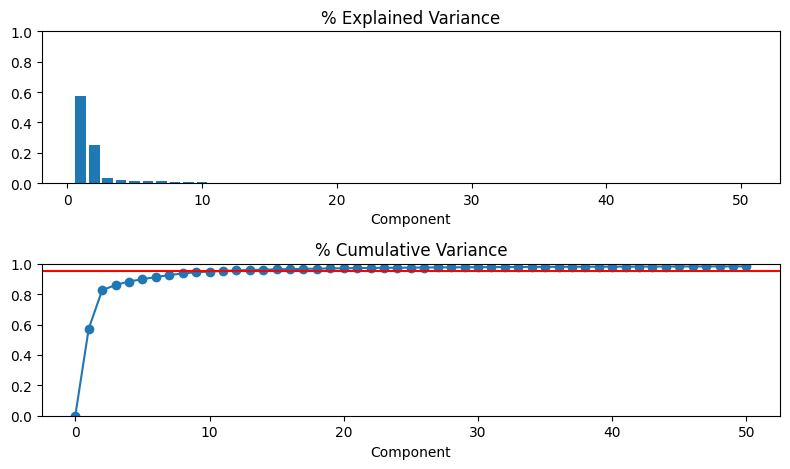

In [ ]:
fig, axs = plt.subplots(2,1)
n = pca.n_components_
grid = np.arange(1, n + 1)
# Explained variance
evr = pca.explained_variance_ratio_
axs[0].bar(grid, evr)
axs[0].set(
    xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
)

# Cumulative Variance
cv = np.cumsum(evr)
axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
axs[1].set(
    xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
)
axs[1].axhline(0.95,color = 'red')
# Set up figure
fig.set(figwidth=8, dpi=100)
plt.tight_layout()


Do we need a kernel? This could be a hyperparameter when testing the validation set.

In [ ]:
y_train

104    1
175    0
223    0
57     1
783    0
      ..
715    0
767    1
72     0
235    0
37     0
Name: label, Length: 661, dtype: int64

In [ ]:
X_train_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50
104,135.532431,-26.778238,158.574580,-61.956183,203.082578,-2.101855,-29.659250,-25.434365,-0.736706,29.448408,...,-11.246648,9.711211,3.475020,-9.080283,-8.200899,7.576692,-4.717358,0.678800,7.048402,-3.258658
175,-48.012793,0.651820,-14.880641,-19.302425,-18.685844,-8.451336,-9.734462,-4.968183,11.674602,-0.948829,...,-4.364736,-8.466871,7.465978,8.215793,16.393386,-3.969582,3.086428,5.485147,-3.313433,-2.449316
223,-38.469589,4.905221,-8.263606,-8.455162,-12.179104,-7.508629,-6.758235,0.614405,6.427969,-6.433942,...,-5.364682,3.390160,-3.422623,2.872809,-1.901838,6.573631,-7.960767,-5.998696,-0.348457,1.602592
57,-35.573717,13.780498,-9.210837,-1.933715,-14.057160,-10.443098,6.526566,-3.053321,4.692064,-1.672041,...,4.259499,4.405719,-5.877847,-2.540515,3.504548,1.486515,-2.386203,6.924400,-3.528936,0.378617
783,153.944017,-29.770542,-57.188124,-53.624600,2.450944,-10.391995,-40.964891,55.005579,-140.866238,35.013926,...,0.080754,-1.699738,1.235389,0.644015,9.392527,3.698893,-3.754988,2.801773,2.664370,1.015540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,-64.339387,19.013381,-9.578621,-9.830020,-1.206449,-10.741063,4.632823,-16.194977,-1.357905,-3.078980,...,6.721320,-10.599975,-1.213757,7.136151,11.317093,-6.260528,-6.866970,-0.254492,-5.267474,4.447316
767,-48.473906,29.728761,2.035763,-13.005051,1.683114,-5.030375,-3.443121,-31.711657,-1.698421,4.638041,...,-0.121016,-1.674458,-2.518506,0.848870,0.788760,-1.844760,5.574533,-5.076053,0.312402,3.026906
72,-48.684590,15.243645,-6.443996,-7.197696,-7.299651,-5.711294,5.495778,-14.507362,1.764922,-6.127806,...,-1.246889,-0.540305,-6.190939,-2.795526,-2.107602,3.003182,-2.627016,4.150853,1.879149,-0.257849
235,54.270797,93.504905,-10.021845,-26.829787,53.845216,21.225054,-60.420296,-75.761025,-0.415162,62.952376,...,-1.469268,0.092999,8.272356,3.239510,-2.501648,-1.009518,6.960139,-3.282697,7.126109,-3.378473


<ipython-input-59-8a095893b256>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0,0].set_xticklabels(mutual_info_pca.index,rotation = 90)
<ipython-input-59-8a095893b256>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0,1].set_xticklabels(mutual_info_kpca.index,rotation = 90)


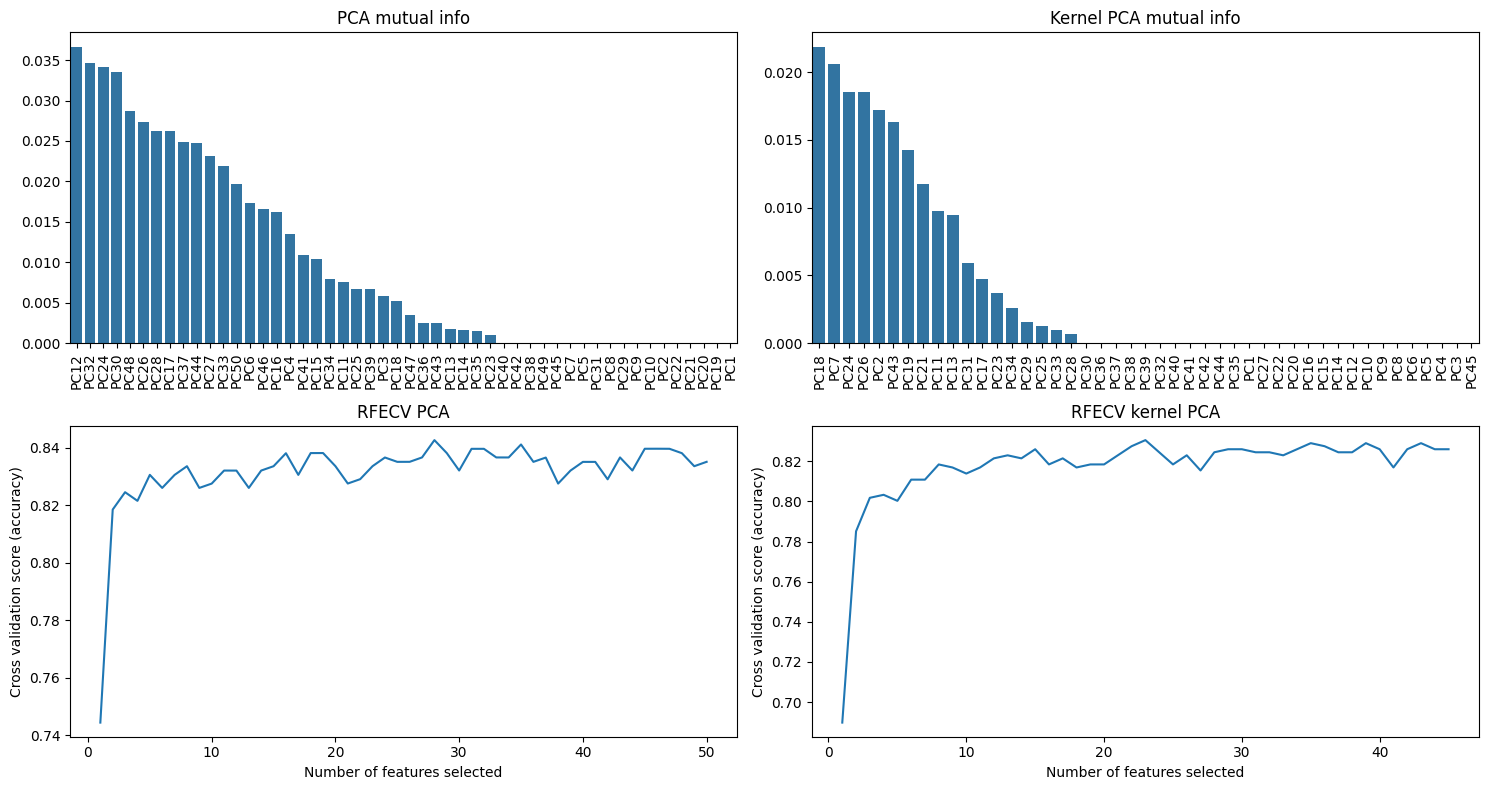

In [ ]:
from sklearn.feature_selection import mutual_info_classif, SelectKBest, RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
# mutual information
fig, axes = plt.subplots(2,2,figsize = [15,8])
mutual_info_kpca = pd.Series(mutual_info_classif(X_train_kpca,y_train),index = X_train_kpca.columns).sort_values(ascending=False)
mutual_info_pca = pd.Series(mutual_info_classif(X_train_pca,y_train),index = X_train_pca.columns).sort_values(ascending=False)

# RFECV
clf = RandomForestClassifier(n_estimators=100, random_state=1)
rfecv_pca = RFECV(estimator=clf, step=1, cv=StratifiedKFold(5), scoring='accuracy')
rfecv_pca.fit(X_train_pca, y_train)

rfecv_kpca = RFECV(estimator=clf, step=1, cv=StratifiedKFold(5), scoring='accuracy')
rfecv_kpca.fit(X_train_kpca, y_train)

# figures Mutual information
sns.barplot(mutual_info_pca, ax = axes[0,0])
axes[0,0].set_title('PCA mutual info')
axes[0,0].set_xticklabels(mutual_info_pca.index,rotation = 90)
sns.barplot(mutual_info_kpca,ax = axes[0,1])
axes[0,1].set_title('Kernel PCA mutual info')
axes[0,1].set_xticklabels(mutual_info_kpca.index,rotation = 90)

# figures RFECV
axes[1,0].set_xlabel("Number of features selected")
axes[1,0].set_ylabel("Cross validation score (accuracy)")
axes[1,0].set_title("RFECV PCA")
axes[1,0].plot(range(1, len(rfecv_pca.cv_results_['mean_test_score']) + 1), rfecv_pca.cv_results_['mean_test_score'])

axes[1,1].set_xlabel("Number of features selected")
axes[1,1].set_ylabel("Cross validation score (accuracy)")
axes[1,1].set_title("RFECV kernel PCA")
axes[1,1].plot(range(1, len(rfecv_kpca.cv_results_['mean_test_score']) + 1), rfecv_kpca.cv_results_['mean_test_score'])

plt.tight_layout()

For high-dimensional problems, pre-processing with PCA (meaning reducing dimensionality and keeping only top PCs) can be seen as one way of regularization and will often improve the results of any subsequent analysis, be it a regression or a classification method. But there is no guarantee that this will work, and there are often better regularization approaches.

MAYBE LASSO WORKS BETTER for selection of features?

We chose mutual information because it looks at non-linear relations between the data and the label. There is no information that when the data increases, the labels increase linearly.

In [ ]:
# Print the optimal number of features selected
print("Optimal number of features selected:", rfecv_pca.n_features_)

# Print the ranking of each feature (1 = selected, 2 = not selected)
print("Feature ranking:", rfecv_pca.ranking_)

# Print the support mask indicating which features are selected
print("Support mask:", rfecv_pca.support_)
print('Informative features', rfecv_pca.support_*X_train_pca.columns)

Optimal number of features selected: 28
Feature ranking: [ 7 14  1  3  1 20 21  1  1 15  1 16 13  1  8  1  1 12  1  1 10  2 23  6
  1  1  1  1  1  1  9  1  1  1 19 22  1  1  1  1 11 18 17  1  4  1  1  1
  5  1]
Support mask: [False False  True False  True False False  True  True False  True False
 False  True False  True  True False  True  True False False False False
  True  True  True  True  True  True False  True  True  True False False
  True  True  True  True False False False  True False  True  True  True
 False  True]
Informative features Index(['', '', 'PC3', '', 'PC5', '', '', 'PC8', 'PC9', '', 'PC11', '', '',
       'PC14', '', 'PC16', 'PC17', '', 'PC19', 'PC20', '', '', '', '', 'PC25',
       'PC26', 'PC27', 'PC28', 'PC29', 'PC30', '', 'PC32', 'PC33', 'PC34', '',
       '', 'PC37', 'PC38', 'PC39', 'PC40', '', '', '', 'PC44', '', 'PC46',
       'PC47', 'PC48', '', 'PC50'],
      dtype='object')


Following RFECV: these features are most important (n=44). This roughly corresponds with the mutual information plot. Conclusion: if we use PCA we should retain many PCA features (>44). The first PC's don't show the most 'predictiveness', PC2 and PC4 are removed bij RFECV.

In [ ]:
# Selecting the 20th best - subjective chosen and applied to the test data
select_kbest = SelectKBest(mutual_info_classif, k=20)
select_kbest.fit_transform(X_train_pca,y_train)

X_train_pca_select = pd.DataFrame(X_train_pca, columns =select_kbest.get_feature_names_out(),index = X_train.index)
X_test_pca_select = pd.DataFrame(X_test_pca[select_kbest.get_feature_names_out()],columns =select_kbest.get_feature_names_out(), index = X_test.index)

<ipython-input-100-6cb4b64879a4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_pca_vis['label'] = y_train


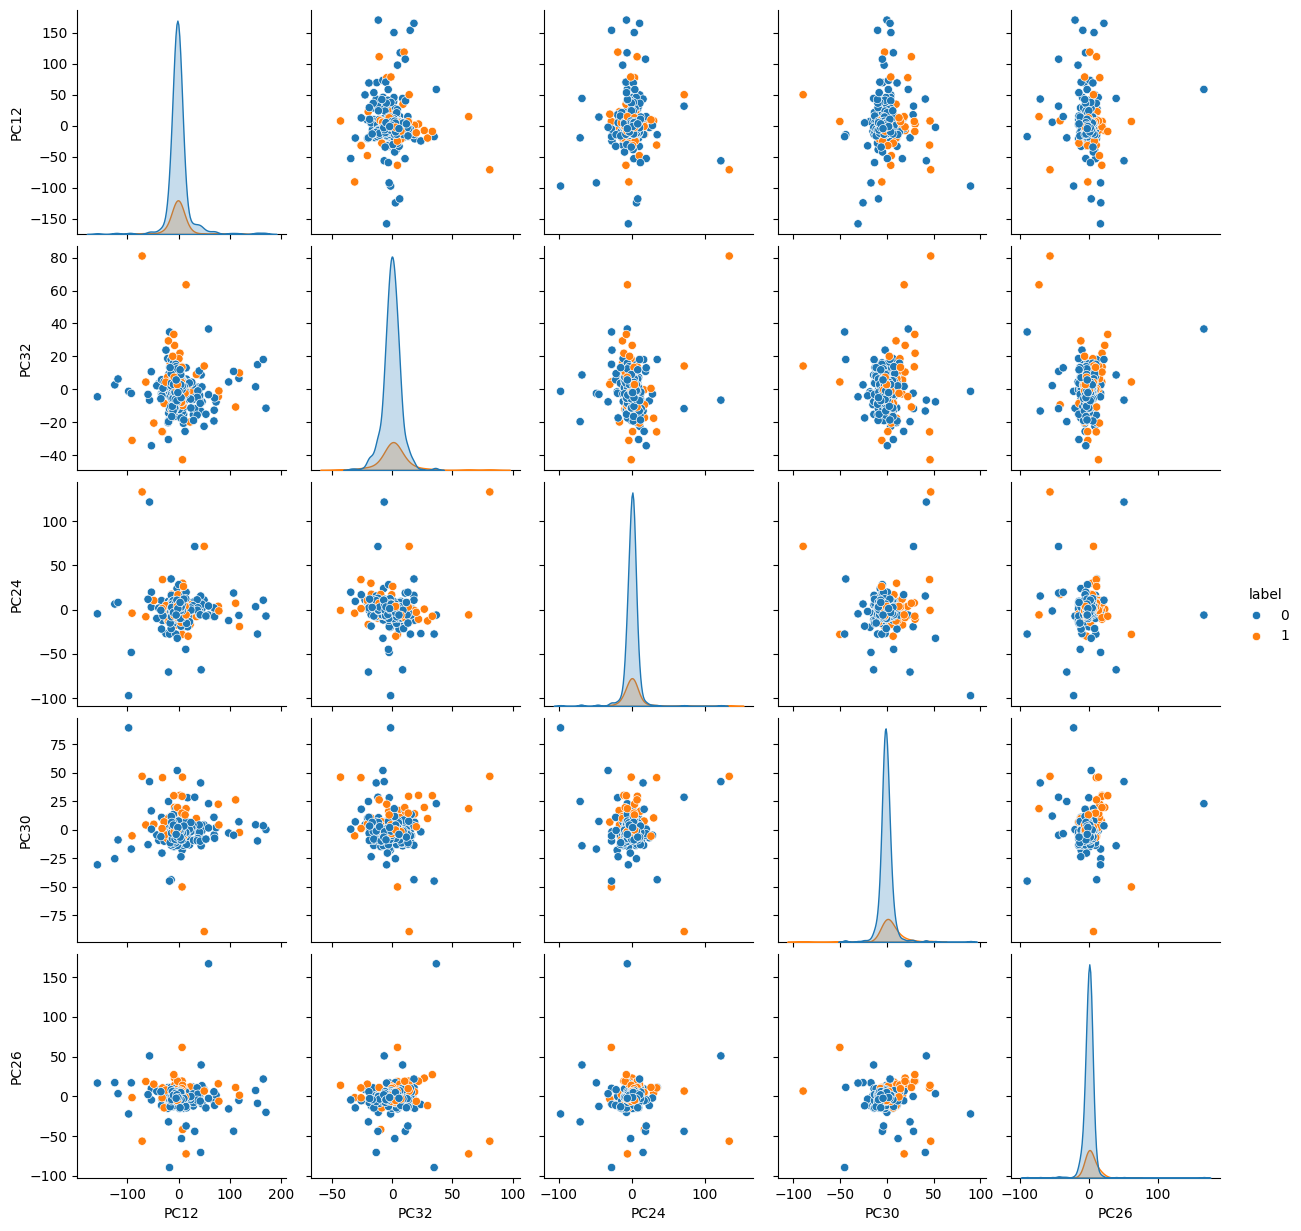

In [ ]:
# linear PCA: top PC features to distinct labels
X_train_pca_vis = X_train_pca_select[['PC12','PC32','PC24','PC30','PC26']]
X_train_pca_vis['label'] = y_train
sns.pairplot(data=X_train_pca_vis,hue = 'label')

Conclusions:
*   The first 12 principal components are sufficient for feature selection. These 12 features explain 95% of the variance in the dataset (expected variance figure) and using RFECV we saw that after adding 12 features the accuracy did not increase.
*  We chose a threshold of 95% for the expected variance because a higher threshold (for example 99%) yielded significant more principial components.
*   Another conclusion is that PC1 which explains the variance for more than 50% doesn't seem to be the best feature for predicting the label and should be dropped. We can explain this because the PCA is linear and the data cannot be seperated linearly with PCA.
*   Trying other kernels? As hyperparameters?






# Validation step

# PCA hyperparameters

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Create a grid search to find the optimal k using a gridsearch and 10-fold cross validation
# Define the parameter grid for grid search
param_grid_random = {
    'kpca__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Kernels to search over
    'kpca__gamma': [0.1, 1, 10],  # Values for gamma parameter (for 'rbf', 'poly', 'sigmoid' kernels)
    'kpca__degree': [2, 3, 4],    # Values for degree parameter (for 'poly' kernel)
    'classifier__n_estimators': [100],  # Number of trees in the forest
    'classifier__max_depth': [None],  # Maximum depth of the trees
    'classifier__min_samples_split': [10],   # Minimum number of samples required to split a node
    'classifier__min_samples_leaf': [4]      # Minimum number of samples required at each leaf node
}

# Create a pipeline with Kernel PCA and a classifier (e.g., SVC)
pipeline = Pipeline([
    ('kpca', KernelPCA()),
    ('classifier', RandomForestClassifier(random_state=43))
])

# Perform grid search using cross-validation (5-fold cross-validation in this example)
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid_random, cv=5, scoring='accuracy')
grid_search.fit(X_train_pca, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
45 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 359, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/usr/local/lib/python3.10/dist-pac

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('kpca', KernelPCA()),
                                       ('classifier',
                                        RandomForestClassifier(random_state=43))]),
             param_grid={'classifier__max_depth': [None],
                         'classifier__min_samples_leaf': [4],
                         'classifier__min_samples_split': [10],
                         'classifier__n_estimators': [100],
                         'kpca__degree': [2, 3, 4], 'kpca__gamma': [0.1, 1, 10],
                         'kpca__kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
             scoring='accuracy')

In [ ]:
# Print the best parameters found
print("Best parameters:", grid_search.best_params_)

# Print the best cross-validation score found
print("Best cross-validation score:", grid_search.best_score_)

Best parameters: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 100, 'kpca__degree': 2, 'kpca__gamma': 0.1, 'kpca__kernel': 'linear'}
Best cross-validation score: 0.8487012987012987


# Regularisation Lasso

Testing the regularisation L1 method

In [ ]:
from sklearn.linear_model import Lasso

# Create a Lasso regression model
lasso_model = Lasso(alpha=0.1)  # Set the regularization strength (alpha)
lasso_model.fit(X_train_scaled,y_train)

param_grid = {'alpha': [0.1,1,10]}
# Fit the model to the training data
gridsearch_lasso = GridSearchCV(estimator = lasso_model,param_grid = param_grid, cv = 5, scoring= 'accuracy')
gridsearch_lasso.fit(X_train_scaled,y_train)

lasso_model_best = gridsearch_lasso.best_estimator_
# Predict on the test data
y_pred = lasso_model.predict(X_test_scaled)

# Print the coefficients of the model
print('Optimal parameters',gridsearch_lasso.best_params_)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 221, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
 

Optimal parameters {'alpha': 0.1}
Coefficients: [-0. -0. -0. ... -0.  0. -0.]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(


array([0.12461443, 0.12582014, 0.18610859, 0.15137443, 0.11042438,
       0.13112202, 0.13375947, 0.16140438, 0.13125705, 0.13639022,
       0.14858881, 0.12710642, 0.14213759, 0.23696562, 0.13401345,
       0.16444615, 0.14199763, 0.11421355, 0.17687413, 0.18323479,
       0.16268166, 0.16233098, 0.18437658, 0.14418327, 0.16790681,
       0.3533542 , 0.13802189, 0.1069595 , 0.11794842, 0.10820022,
       0.11396928, 0.15059051, 0.15192746, 0.14625362, 0.12227957,
       0.34087632, 0.15436534, 0.12473886, 0.12236884, 0.32772017,
       0.25065359, 0.22600047, 0.1448477 , 0.17022487, 0.1424254 ,
       0.20720448, 0.1461025 , 0.25141458, 0.25477479, 0.10601013,
       0.50458852, 0.12319327, 0.16611327, 0.2638203 , 0.11103532,
       0.13514859, 0.18437574, 0.14639487, 0.11805687, 0.12064677,
       0.13154716, 0.67211139, 0.17951738, 0.14053319, 0.12447936,
       0.14143024, 0.2046038 , 0.20168749, 0.23814006, 0.39448405,
       0.16280365, 0.13142384, 0.12140778, 0.16279231, 0.14858

In [ ]:
y_train

104    1
175    0
223    0
57     1
783    0
      ..
715    0
767    1
72     0
235    0
37     0
Name: label, Length: 661, dtype: int64

In [ ]:
y_test

370    0
449    0
808    0
576    0
570    0
      ..
135    0
760    0
309    1
134    0
242    0
Name: label, Length: 166, dtype: int64

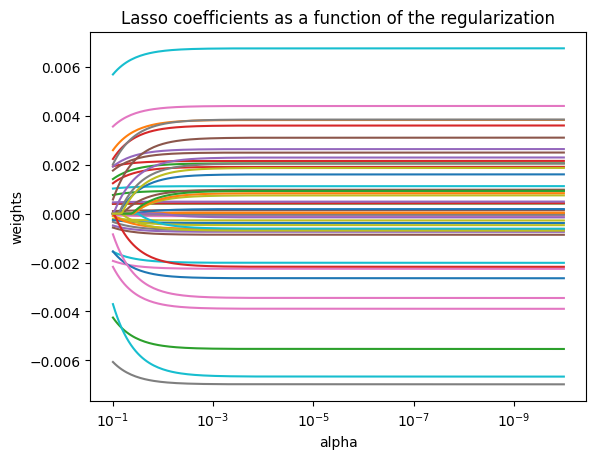

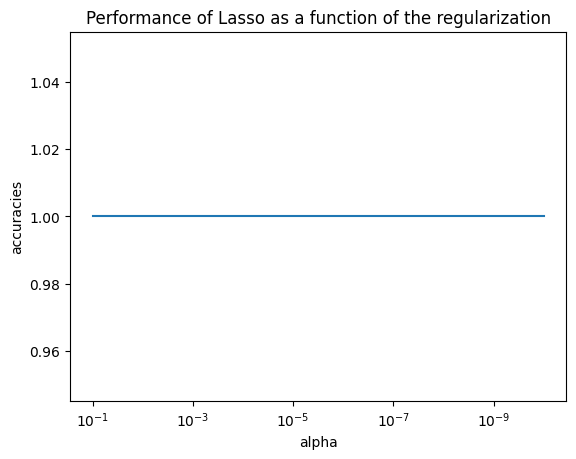

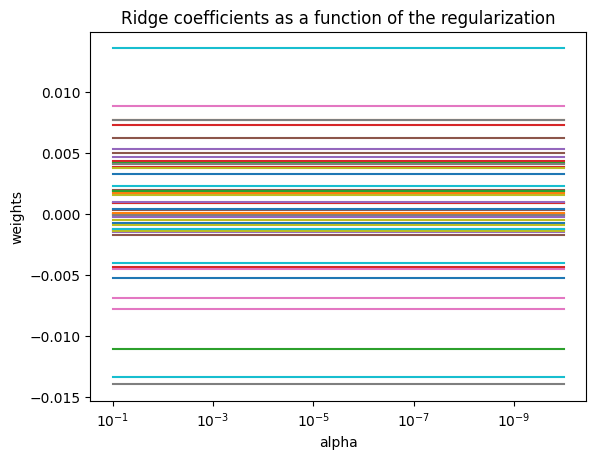

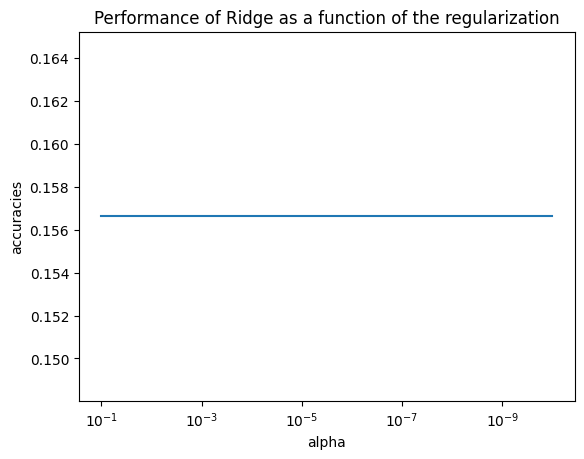

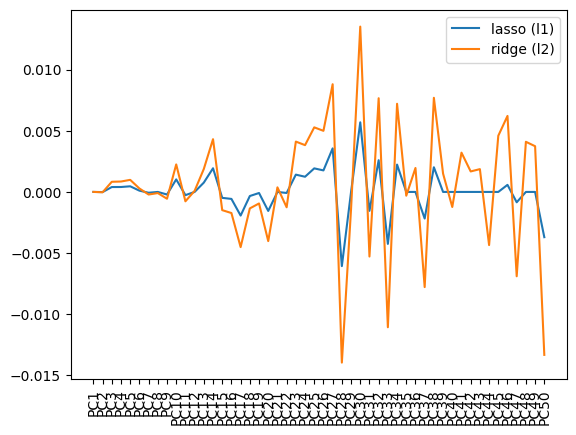

In [ ]:
from sklearn.linear_model import RidgeClassifier

# Construct classifiers
coefs_lasso = []
accuracies_lasso = []
coefs_ridge = []
accuracies_ridge = []
for a in alphas:
    # Fit Lasso classifier
    clf_lasso = Lasso(alpha=a)
    clf_lasso.fit(X_train_pca, y_train)
    y_pred_lasso = clf_lasso.predict(X_test_pca)

    # Append statistics for Lasso
    accuracy_lasso = float((y_test != y_pred_lasso).sum()) / float(y_test.shape[0])
    accuracies_lasso.append(accuracy_lasso)
    coefs_lasso.append(clf_lasso.coef_)

    # Fit Ridge classifier
    clf_ridge = RidgeClassifier(alpha=a)
    clf_ridge.fit(X_train_pca, y_train)
    y_pred_ridge = clf_ridge.predict(X_test_pca)

    # Append statistics for Ridge
    accuracy_ridge = float((y_test != y_pred_ridge).sum()) / float(y_test.shape[0])
    accuracies_ridge.append(accuracy_ridge)
    coefs_ridge.append(clf_ridge.coef_)

# #############################################################################
# Display results for Lasso

# Weights for Lasso
plt.figure()
ax = plt.gca()
ax.plot(alphas, np.squeeze(coefs_lasso))
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

# Performance for Lasso
plt.figure()
ax = plt.gca()
ax.plot(alphas, accuracies_lasso)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('accuracies')
plt.title('Performance of Lasso as a function of the regularization')
plt.axis('tight')
plt.show()

# #############################################################################
# Display results for Ridge

# Weights for Ridge
plt.figure()
ax = plt.gca()
ax.plot(alphas, np.squeeze(coefs_ridge))
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

# Performance for Ridge
plt.figure()
ax = plt.gca()
ax.plot(alphas, accuracies_ridge)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('accuracies')
plt.title('Performance of Ridge as a function of the regularization')
plt.axis('tight')
plt.show()

# Joint plot
plt.figure()
plt.plot(X_train_pca.columns,clf_lasso.coef_.flatten())
plt.plot(X_train_pca.columns,clf_ridge.coef_.flatten())
plt.xticks(rotation = 90)
plt.legend(['lasso (l1)','ridge (l2)'])

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49],
 [Text(0, 0, 'PC1'),
  Text(1, 0, 'PC2'),
  Text(2, 0, 'PC3'),
  Text(3, 0, 'PC4'),
  Text(4, 0, 'PC5'),
  Text(5, 0, 'PC6'),
  Text(6, 0, 'PC7'),
  Text(7, 0, 'PC8'),
  Text(8, 0, 'PC9'),
  Text(9, 0, 'PC10'),
  Text(10, 0, 'PC11'),
  Text(11, 0, 'PC12'),
  Text(12, 0, 'PC13'),
  Text(13, 0, 'PC14'),
  Text(14, 0, 'PC15'),
  Text(15, 0, 'PC16'),
  Text(16, 0, 'PC17'),
  Text(17, 0, 'PC18'),
  Text(18, 0, 'PC19'),
  Text(19, 0, 'PC20'),
  Text(20, 0, 'PC21'),
  Text(21, 0, 'PC22'),
  Text(22, 0, 'PC23'),
  Text(23, 0, 'PC24'),
  Text(24, 0, 'PC25'),
  Text(25, 0, 'PC26'),
  Text(26, 0, 'PC27'),
  Text(27, 0, 'PC28'),
  Text(28, 0, 'PC29'),
  Text(29, 0, 'PC30'),
  Text(30, 0, 'PC31'),
  Text(31, 0, '

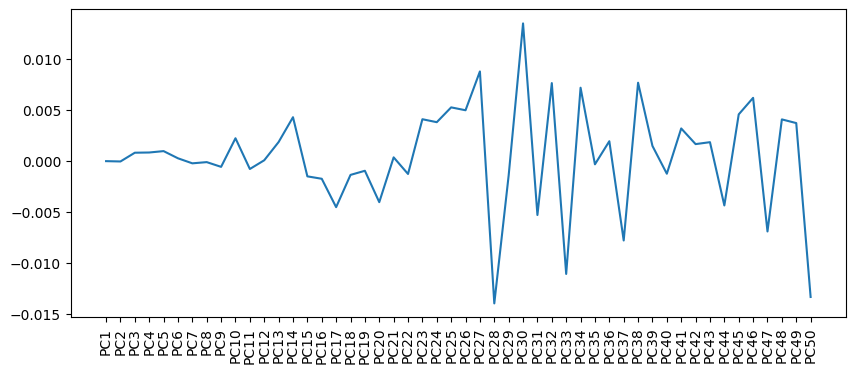

# Evaluating with validation set

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Create a grid search to find the optimal k using a gridsearch and 10-fold cross validation
# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],   # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4]      # Minimum number of samples required at each leaf node
}

# Create a pipeline with Kernel PCA and a classifier (e.g., SVC)
random_forest = RandomForestClassifier(random_state=43)

# Perform grid search using cross-validation (5-fold cross-validation in this example)
grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv=5, scoring='accuracy',verbose = 2)
grid_search.fit(X_train_pca, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_de

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=43),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=2)

In [ ]:
# Print the best parameters found
print("Best parameters:", grid_search.best_params_)

# Print the best cross-validation score found
print("Best cross-validation score:", grid_search.best_score_)

print('Best model:', grid_search.best_estimator_)

Best parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}
Best cross-validation score: 0.8457051720209614
Beast model: RandomForestClassifier(min_samples_leaf=4, min_samples_split=10,
                       n_estimators=50, random_state=43)


In [ ]:
from sklearn.metrics import accuracy_score

clf = grid_search.best_estimator_
y_predict = clf.predict(X_test_pca)
score = accuracy_score(y_test,y_predict)
score

0.8192771084337349